<a href="https://colab.research.google.com/github/doudi25/Sentiment_analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Twitter dataset available @ https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

In [ ]:
!unzip  file.zip

Archive:  file.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd

# Read the training data from a CSV file into a DataFrame
train_df = pd.read_csv('train.csv')

# Count the occurrences of binary labels in the 'label' column
label_counts = train_df['label'].value_counts()
label_counts

label
0    29720
1     2242
Name: count, dtype: int64

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2024-04-12 14:12:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.27MB/s    in 2m 41s  

2024-04-12 14:15:32 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import numpy as np

# Create an empty dictionary to store word embeddings
words = dict()

# Function to add word embeddings to the dictionary
def add_to_dict(d, filename):
    # Open the file containing word embeddings
    with open(filename, 'r') as f:
        # Iterate through each line in the file
        for line in f.readlines():
            # Split the line into word and its embedding components
            line = line.split(' ')
            try:
                # Convert the embedding components to a NumPy array
                # and store it in the dictionary with the word as key
                d[line[0]] = np.array(line[1:], dtype=float)
            except:
                # Skip the line if it cannot be parsed (e.g., if it's a header)
                continue

# Call the function to add word embeddings from the specified file
add_to_dict(words, 'glove.6B.50d.txt')
words

In [ ]:
import spacy
# Load the english model
nlp = spacy.load("en_core_web_sm")



In [ ]:
def message_to_token_list(s):
    """
    Tokenize a message and return a list of useful tokens.

    Args:
    - s (str): The input message to tokenize.

    Returns:
    - list: A list of useful tokens extracted from the message.
    """
    # Tokenize the input message and lemmatize each token
    lemmatized_tokens = [token.lemma_ for token in nlp(s.lower())]
    # Filter out tokens that are not present in the word embedding dictionary
    useful_tokens = [t for t in lemmatized_tokens if t in words]
    return useful_tokens

In [ ]:
def message_to_word_vectors(message, word_dict=words):
    """
    Convert a message into a sequence of word vectors using a pre-trained word embedding dictionary.

    Args:
    - message (str): The input message to convert.
    - word_dict (dict): A dictionary mapping words to their corresponding word vectors.

    Returns:
    - numpy.ndarray: An array containing the word vectors for each token in the message.
    """
    # Tokenize the message into a list of tokens
    processed_list_of_tokens = message_to_token_list(message)
    vectors = []
    # Iterate through each token in the tokenized message
    for token in processed_list_of_tokens:
        # Check if the token exists in the word dictionary
        if token not in word_dict:
            continue
        # Retrieve the word vector corresponding to the token
        token_vector = word_dict[token]
        # Append the word vector to the list of vectors
        vectors.append(token_vector)
    # Convert the list of vectors to a numpy array
    return np.array(vectors, dtype=float)


In [ ]:
from sklearn.model_selection import train_test_split

# Shuffle the data
train_df_shuffled = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(train_df_shuffled, test_size=0.3, random_state=1)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=1)


In [ ]:
def df_to_X_y(dff):
    """
    Convert DataFrame to input features (X) and labels (y).

    Args:
    - dff: DataFrame containing 'tweet' and 'label' columns.

    Returns:
    - X: List of word vector sequences for each tweet.
    - y: Array of labels.
    """
    # Extract labels from DataFrame and convert to numpy array
    y = dff['label'].to_numpy().astype(int)

    # Convert each tweet to a sequence of word vectors
    all_word_vector_sequences = []

    for message in dff['tweet']:
        # Convert message to word vectors
        message_as_vector_seq = message_to_word_vectors(message)

        # Handle empty sequences by replacing with a zero vector
        if message_as_vector_seq.shape[0] == 0:
            message_as_vector_seq = np.zeros(shape=(1, 50))

        all_word_vector_sequences.append(message_as_vector_seq)

    return all_word_vector_sequences, y




In [ ]:
X_train, y_train = df_to_X_y(train_df)

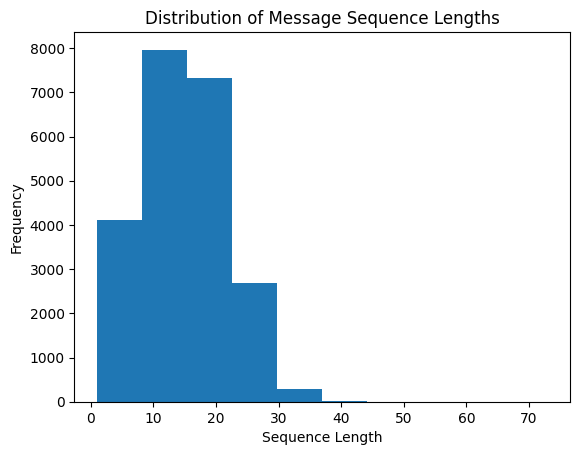

In [ ]:
import matplotlib.pyplot as plt

# Initialize list to store sequence lengths
sequence_lengths = []

# Iterate over each message in the training set
for i in range(len(X_train)):
    # Append the length of the current message to the list
    sequence_lengths.append(len(X_train[i]))

# Plot histogram of sequence lengths
plt.hist(sequence_lengths)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Sequence Lengths')
plt.show()


In [ ]:
pd.Series(sequence_lengths).describe()

count    22373.000000
mean        14.912707
std          6.540725
min          1.000000
25%         10.000000
50%         15.000000
75%         20.000000
max         73.000000
dtype: float64

In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=75):
    """
    Pad sequences in X to desired sequence length.

    Args:
    - X (np.ndarray): Array of sequence vectors.
    - desired_sequence_length (int): Desired sequence length after padding.

    Returns:
    - np.ndarray: Padded array of sequence vectors.
    """
    # Create a deep copy of X to avoid modifying the original array
    X_copy = deepcopy(X)

    # Iterate over each sequence vector in X
    for i, x in enumerate(X):
        # Get the length of the current sequence
        x_seq_len = x.shape[0]

        # Calculate the difference between the desired sequence length and the current sequence length
        sequence_length_difference = desired_sequence_length - x_seq_len

        # Create a padding array of zeros with the appropriate shape
        pad = np.zeros(shape=(sequence_length_difference, 50))

        # Concatenate the padding array to the end of the current sequence vector
        X_copy[i] = np.concatenate([x, pad])

    # Convert the padded array to float and return
    return np.array(X_copy).astype('float')



In [ ]:
X_train=pad_X(X_train)

#Tensor of 22373 sentences , each sentence is made of 75 words whether is padding with zeros or original lengt
#each word represented with length of 50 in the embedded space
X_train.shape

(22373, 75, 50)

In [ ]:
X_val,y_val=df_to_X_y(val_df)

X_val=pad_X(X_val)

X_val.shape


(4794, 75, 50)

In [ ]:
X_test, y_test = df_to_X_y(test_df)

X_test = pad_X(X_test)

X_test.shape

(4795, 75, 50)

In [ ]:
from keras import layers
from keras.models import Sequential

In [ ]:
model=Sequential([])
model.add(layers.Input(shape=(75,50)))
model.add(layers.LSTM(64,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 75, 64)            29440     
                                                                 
 dropout (Dropout)           (None, 75, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 75, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 75, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 75, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 75, 64)            0         
                                                                 
 flatten (Flatten)           (None, 4800)              0

In [ ]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback to save the best model during training
cp = ModelCheckpoint('model/', save_best_only=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Using Adam optimizer with a specific learning rate
              loss=BinaryCrossentropy(),  # Using Binary Crossentropy loss function
              metrics=['accuracy', AUC(name='auc')])  # Monitoring accuracy and AUC metrics during training


In [ ]:
frequencies = pd.value_counts(train_df['label'])

frequencies

label
0    20794
1     1579
Name: count, dtype: int64

In [ ]:
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.0759353659709532, 1: 14.169094363521216}

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
700/700 [==============================] - 39s 36ms/step - loss: 1.0620 - accuracy: 0.7601 - auc: 0.8107 - val_loss: 0.3018 - val_accuracy: 0.8761 - val_auc: 0.8874
Epoch 2/20
700/700 [==============================] - 10s 14ms/step - loss: 0.8733 - accuracy: 0.7970 - auc: 0.8795 - val_loss: 0.3968 - val_accuracy: 0.8171 - val_auc: 0.8967
Epoch 3/20
700/700 [==============================] - 18s 25ms/step - loss: 0.8237 - accuracy: 0.8099 - auc: 0.8938 - val_loss: 0.4158 - val_accuracy: 0.8089 - val_auc: 0.9006
Epoch 4/20
700/700 [==============================] - 16s 23ms/step - loss: 0.7955 - accuracy: 0.8200 - auc: 0.9015 - val_loss: 0.3711 - val_accuracy: 0.8338 - val_auc: 0.9049
Epoch 5/20
700/700 [==============================] - 14s 21ms/step - loss: 0.7684 - accuracy: 0.8247 - auc: 0.9082 - val_loss: 0.4336 - val_accuracy: 0.7958 - val_auc: 0.9073
Epoch 6/20
700/700 [==============================] - 19s 27ms/step - loss: 0.7508 - accuracy: 0.8264 - auc: 0.9125 - va

In [ ]:
from keras.models import load_model

best_model = load_model('model/')


In [ ]:
# Generate predictions on the test set using the best_model
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

# Import the classification_report function from sklearn.metrics
from sklearn.metrics import classification_report

# Print the classification report, which includes precision, recall, F1-score, and support for each class
print(classification_report(y_test, test_predictions))


150/150 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4478
           1       0.38      0.70      0.49       317

    accuracy                           0.90      4795
   macro avg       0.68      0.81      0.72      4795
weighted avg       0.94      0.90      0.92      4795

